# Shopping Cart Abandonment Prediction
## Data Preparation
Data from https://www.kaggle.com/chadgostopp/recsys-challenge-2015

Place data files in `data` directory relative to this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

Organize click events by Session ID:

In [2]:
# Dictionary to store lists of click events by session ID
X_dict = {}

filepath = 'data/yoochoose-clicks.dat'
with open(filepath) as f:
    count = 0
    for line in f:
        count += 1
        d = line.strip().split(',')
        x = []
        
        # Timestamp
        timestamp = datetime.fromisoformat(d[1][:-1])
        x.append(timestamp.year)
        x.append(timestamp.month)
        x.append(timestamp.day)
        x.append(timestamp.hour)
        x.append(timestamp.minute)
        
        # Item ID
        x.append(int(d[2]))
        
        # Category ID
        # These are all positive integers except for 'S' which indicates a special offer.
        # We set 'S' to -1 to avoid conflict with the other category IDs.
        if d[3] == 'S':
            x.append(-1)
        else:
            x.append(int(d[3]))
        
        # Session ID
        sid = int(d[0])
        if sid not in X_dict:
            X_dict[sid] = []
        X_dict[sid].append(x)
        
        if count % 1_000_000 == 0:
            print('.', end='')

print(f"\nProcessed {count} click events.")

.................................
Processed 33003944 click events.


Collect the set of session IDs that have buy events:

In [3]:
buy_sessions = set()

filepath = 'data/yoochoose-buys.dat'
with open(filepath) as f:
    count = 0
    for line in f:
        count += 1
        d = line.strip().split(',')
        
        # Session ID
        sid = int(d[0])
        buy_sessions.add(sid)
        
        if count % 100_000 == 0:
            print('.', end='')

print(f"\nProcessed {count} buy events.")

...........
Processed 1150753 buy events.


The majority of sessions have shorter length, but there are some sessions with very long length. Our model training will require less resources and training time if we can reduce the maximum session length. We remove sessions greater than a chosen maximum. Since there are so few session examples with long length, we hypothesize that removing them will have small impact on the trained model.

Total Session count: 9249729
Reduced Session count: 9211993
Min session length: 1
Max session length: 25


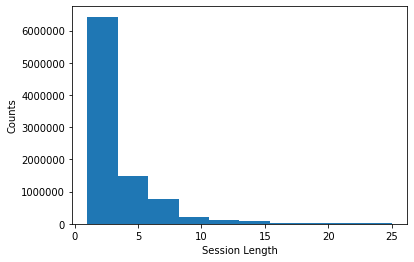

In [4]:
MAX_SESSION_LEN = 25

sessions_to_remove = []

print(f"Total Session count: {len(X_dict.keys())}")
sess_lens = []
for k, v in X_dict.items():
    if len(v) <= MAX_SESSION_LEN:
        sess_lens.append(len(v))
    else:
        sessions_to_remove.append(k)
        
for k in sessions_to_remove:
    X_dict.pop(k)

sess_lens = np.array(sess_lens)
print(f"Reduced Session count: {len(X_dict.keys())}")
print(f"Min session length: {np.min(sess_lens)}")
print(f"Max session length: {np.max(sess_lens)}")

plt.hist(sess_lens)
plt.ylabel('Counts')
plt.xlabel('Session Length');
plt.show()

Generate the training data. For each session $x = [x_1,x_2,\ldots,x_m]$, apply a label $y \in [0,1]$ indicating whether a purchase was made (1) or not made (0).

In [5]:
X = []
y = []

count = 0
for k,v in X_dict.items():
    count += 1
    y_val = 0
    if k in buy_sessions:
        y_val = 1
    
    X.append(v)
    y.append(y_val)
    
    if count % 1_000_000 == 0:
        print('.', end='')

print()
n = 25
print(f"Top {n} samples:")
for i in range(n):
    print()
    print(X[i], y[i])

.........
Top 25 samples:

[[2014, 4, 7, 10, 51, 214536502, 0], [2014, 4, 7, 10, 54, 214536500, 0], [2014, 4, 7, 10, 54, 214536506, 0], [2014, 4, 7, 10, 57, 214577561, 0]] 0

[[2014, 4, 7, 13, 56, 214662742, 0], [2014, 4, 7, 13, 57, 214662742, 0], [2014, 4, 7, 13, 58, 214825110, 0], [2014, 4, 7, 13, 59, 214757390, 0], [2014, 4, 7, 14, 0, 214757407, 0], [2014, 4, 7, 14, 2, 214551617, 0]] 0

[[2014, 4, 2, 13, 17, 214716935, 0], [2014, 4, 2, 13, 26, 214774687, 0], [2014, 4, 2, 13, 30, 214832672, 0]] 0

[[2014, 4, 7, 12, 9, 214836765, 0], [2014, 4, 7, 12, 26, 214706482, 0]] 0

[[2014, 4, 6, 16, 58, 214701242, 0], [2014, 4, 6, 17, 2, 214826623, 0]] 0

[[2014, 4, 2, 6, 38, 214826835, 0], [2014, 4, 2, 6, 39, 214826715, 0]] 0

[[2014, 4, 6, 8, 49, 214838855, 0], [2014, 4, 6, 8, 52, 214838855, 0]] 0

[[2014, 4, 6, 11, 26, 214576500, 0], [2014, 4, 6, 11, 28, 214576500, 0], [2014, 4, 6, 11, 29, 214576500, 0]] 0

[[2014, 4, 3, 10, 44, 214821275, 0], [2014, 4, 3, 10, 45, 214821275, 0], [2014, 4, 3,

Pickle the transformed data into files so we can load them later for model training.

In [6]:
with open('data/X.pickle', "wb") as f:
    pickle.dump(X, f)
with open('data/y.pickle', "wb") as f:
    pickle.dump(y, f)